In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay, roc_auc_score

In [2]:
df = pd.read_csv("data/Exercise2DataSet.csv")
df

,age,LOS,previous_LOS,previous_ICU_stays,cvc_status,SIRS_48_hour,MV_24_hour,Initial_SOFA,Discharge_SOFA,Max_SOFA,AdmitApache,DischargeApache,sex,Type,death
0,86,160.983333,1.800000,0,0,0,0,6,3,6,66,57,F,Surgical,0
1,61,103.533333,11.433333,0,1,1,0,7,4,7,80,73,F,Surgical,0
2,22,572.383333,14.450000,0,1,1,0,10,4,12,90,74,F,Surgical,0
3,58,51.200000,0.000000,0,1,1,1,7,3,7,78,64,M,Medical,0
4,18,35.116667,0.000000,0,0,1,1,7,2,7,73,49,M,Medical,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,47,114.400000,0.000000,0,0,0,0,3,3,7,64,50,F,Surgical,0
496,47,75.500000,1.216667,0,1,0,0,14,7,14,115,62,M,Medical,0
497,54,781.383333,0.000000,0,1,1,0,13,4,16,117,60,F,Surgical,0
498,76,69.083333,0.000000,0,1,1,0,7,2,7,88,38,F,Surgical,0


In [3]:
dummies = pd.get_dummies(df[["sex", "Type"]], drop_first=True)
dummies

,sex_M,Type_Surgical
0,False,True
1,False,True
2,False,True
3,True,False
4,True,False
...,...,...
495,False,True
496,True,False
497,False,True
498,False,True


In [4]:
df.drop(["sex", "Type"], axis=1, inplace=True)

In [5]:
df = pd.concat([df, dummies], axis=1)

In [6]:
corr_matrix = df.corr()

(15.5, -0.5)

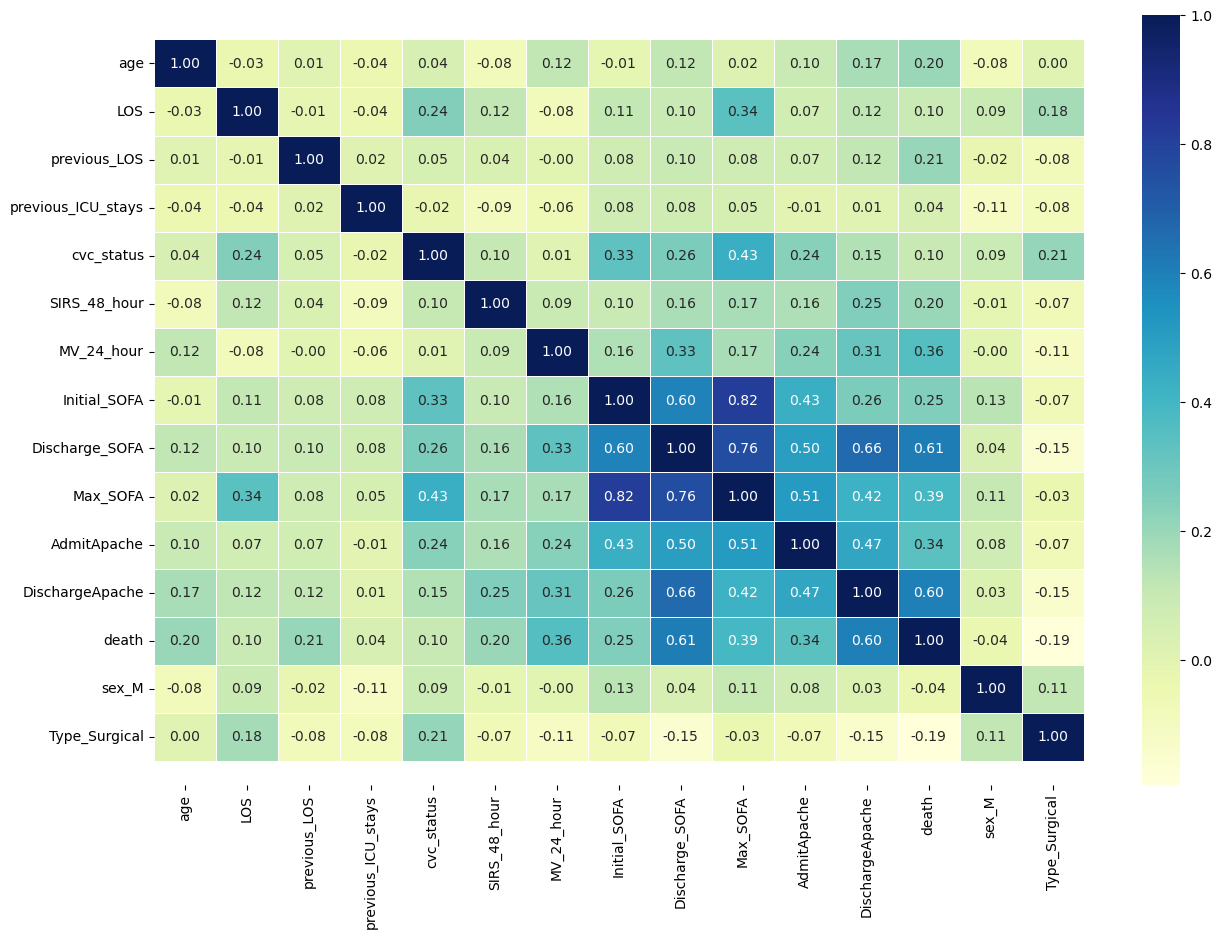

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [8]:
X = df.drop("death", axis=1)
X

,age,LOS,previous_LOS,previous_ICU_stays,cvc_status,SIRS_48_hour,MV_24_hour,Initial_SOFA,Discharge_SOFA,Max_SOFA,AdmitApache,DischargeApache,sex_M,Type_Surgical
0,86,160.983333,1.800000,0,0,0,0,6,3,6,66,57,False,True
1,61,103.533333,11.433333,0,1,1,0,7,4,7,80,73,False,True
2,22,572.383333,14.450000,0,1,1,0,10,4,12,90,74,False,True
3,58,51.200000,0.000000,0,1,1,1,7,3,7,78,64,True,False
4,18,35.116667,0.000000,0,0,1,1,7,2,7,73,49,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,47,114.400000,0.000000,0,0,0,0,3,3,7,64,50,False,True
496,47,75.500000,1.216667,0,1,0,0,14,7,14,115,62,True,False
497,54,781.383333,0.000000,0,1,1,0,13,4,16,117,60,False,True
498,76,69.083333,0.000000,0,1,1,0,7,2,7,88,38,False,True


In [9]:
y = df.death
y

0      0
1      0
2      0
3      0
4      0
      ..
495    0
496    0
497    0
498    0
499    0
Name: death, Length: 500, dtype: int64

In [28]:
# Split data to test and training data sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 14), (100, 14), (400,), (100,))

In [30]:
pipe = Pipeline([("scaler", StandardScaler()), ("model", RandomForestClassifier())])

search_space = [
    {"model": [LogisticRegression(solver="liblinear")],
    "model__C": np.logspace(-4, 4, 100),
    "model__penalty": ["l1", "l2"]},

    {"model": [KNeighborsClassifier()],
     "model__n_neighbors": np.arange(1, 10)},

    {"model": [RandomForestClassifier()],
    "model__n_estimators": np.arange(300, 551, 50),
    "model__max_features": np.arange(1, 10)},

    {"model": [GradientBoostingClassifier()],
    "model__n_estimators": np.arange(300, 551, 50),
    "model__learning_rate": [0.001, 0.01, 0.1]} ]

clf = GridSearchCV(estimator=pipe, param_grid=search_space, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=3),
                   verbose=1, scoring="accuracy")

best_model = clf.fit(X_train, y_train)
print(best_model.best_params_)

Fitting 5 folds for each of 281 candidates, totalling 1405 fits
{'model': LogisticRegression(C=0.007220809018385471, solver='liblinear'), 'model__C': 0.007220809018385471, 'model__penalty': 'l2'}


In [31]:
best_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('model', LogisticRegression(C=0.007220809018385471, solver='liblinear'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'model': LogisticRegression(C=0.007220809018385471, solver='liblinear'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__C': 0.007220809018385471,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 100,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l2',
 'model__random_state': None,
 'model__solver': 'liblinear',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [14]:
best_model.score(X_test, y_test)

0.91

In [15]:
y_pred = best_model.predict(X_test)
y_pred

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0])

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_Standard = scaler.transform(X_train)
X_test_Standard = scaler.transform(X_test)

In [17]:
model = LogisticRegression(C=0.00722080901838547, penalty='l2', solver='liblinear')
model.fit(X_train_Standard, y_train)

LogisticRegression(C=0.00722080901838547, solver='liblinear')

In [18]:
y_pred = model.predict(X_test_Standard)

In [19]:
accuracy_score(y_test, y_pred)

0.91

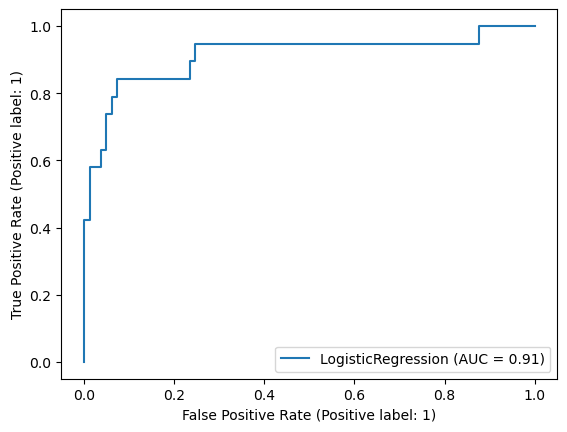

In [20]:
RocCurveDisplay.from_estimator(model, X_test_Standard, y_test)

In [21]:
y_prob = model.predict_proba(X_test_Standard)[:, 1]

In [22]:
roc_auc_score(y_test, y_prob)

0.9122807017543859

In [23]:
print(confusion_matrix(y_test, y_pred))

[[76  5]
 [ 4 15]]


(2.5, -0.5)

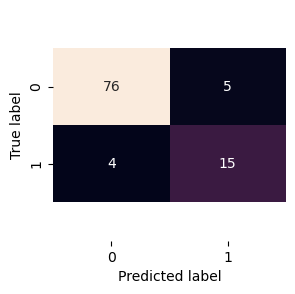

In [24]:
fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False)
plt.xlabel("Predicted label")
plt.ylabel("True label")
    
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94        81
           1       0.75      0.79      0.77        19

    accuracy                           0.91       100
   macro avg       0.85      0.86      0.86       100
weighted avg       0.91      0.91      0.91       100



In [26]:
feature_dict = dict(zip(df.columns, list(model.coef_[0])))
feature_dict

{'age': 0.1061322105206801,
 'LOS': 0.03141334117779251,
 'previous_LOS': 0.13109025603584948,
 'previous_ICU_stays': 0.024526819397036843,
 'cvc_status': -0.004965862322311468,
 'SIRS_48_hour': 0.09848305833189296,
 'MV_24_hour': 0.16814111711621132,
 'Initial_SOFA': 0.03715785647596734,
 'Discharge_SOFA': 0.2568344682564365,
 'Max_SOFA': 0.10766842716329882,
 'AdmitApache': 0.06668548853212403,
 'DischargeApache': 0.2586280649477821,
 'death': -0.020884313622073467,
 'sex_M': -0.08766716286979494}

<Axes: title={'center': 'Coefficients'}>

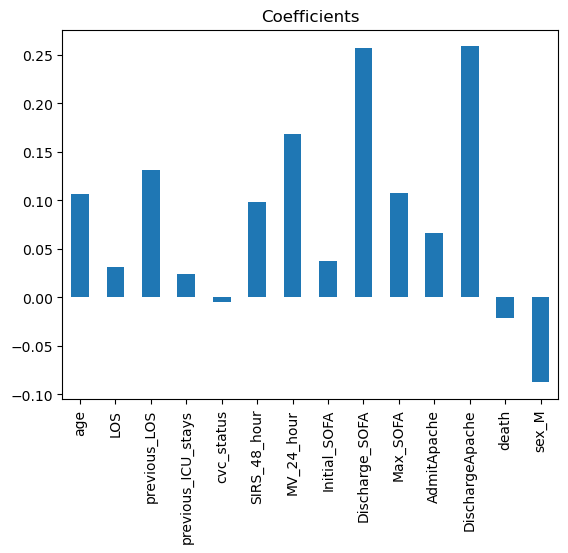

In [27]:
# Visualize coefficients
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Coefficients", legend=False)